In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import mudata as md
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from utils.gglasso_pipeline import gg_lasso_network_analysis
from utils.utils import calc_sparsity
from sklearn.covariance import empirical_covariance
from scipy.stats import pearsonr
from tqdm import tqdm

In [2]:
ec_mudata = md.read("../data/preprocessed/psa_mudata_prepro.h5mu")
ec_mudata

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 112 × 3202
  3 modalities
    all_genes:	112 x 1601
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'neighbors', 'protein_match', 'umap', 'unmatch_genes'
      obsm:	'X_pca', 'X_umap'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
      obsp:	'connectivities', 'distances'
    high_abundance_genes:	112 x 72
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'neighbors', 'protein_match', 'umap', 'unmatch_genes'
      obsm:	'X_pca', 'X_umap'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
      obsp:	'connectivities', 'distances'
    low_abundance_genes:	112 x 1529
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'neighbors', 'protein_match', 'umap', 'unmatch_genes'
      obsm:	'X_pca', 'X_umap'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
      obsp:	'connectivities', 'distances'

### Mean and Median of cell counts

In [3]:
print(np.mean(np.sum(ec_mudata["high_abundance_genes"].X.A, axis=1)))
print(np.median(np.sum(ec_mudata["high_abundance_genes"].X.A, axis=1)))

18.3125
8.0


### Mean and Median of gene counts

In [4]:
print(np.mean(np.sum(ec_mudata["high_abundance_genes"].X.A, axis=0)))
print(np.median(np.sum(ec_mudata["high_abundance_genes"].X.A, axis=0)))

28.48611
19.0


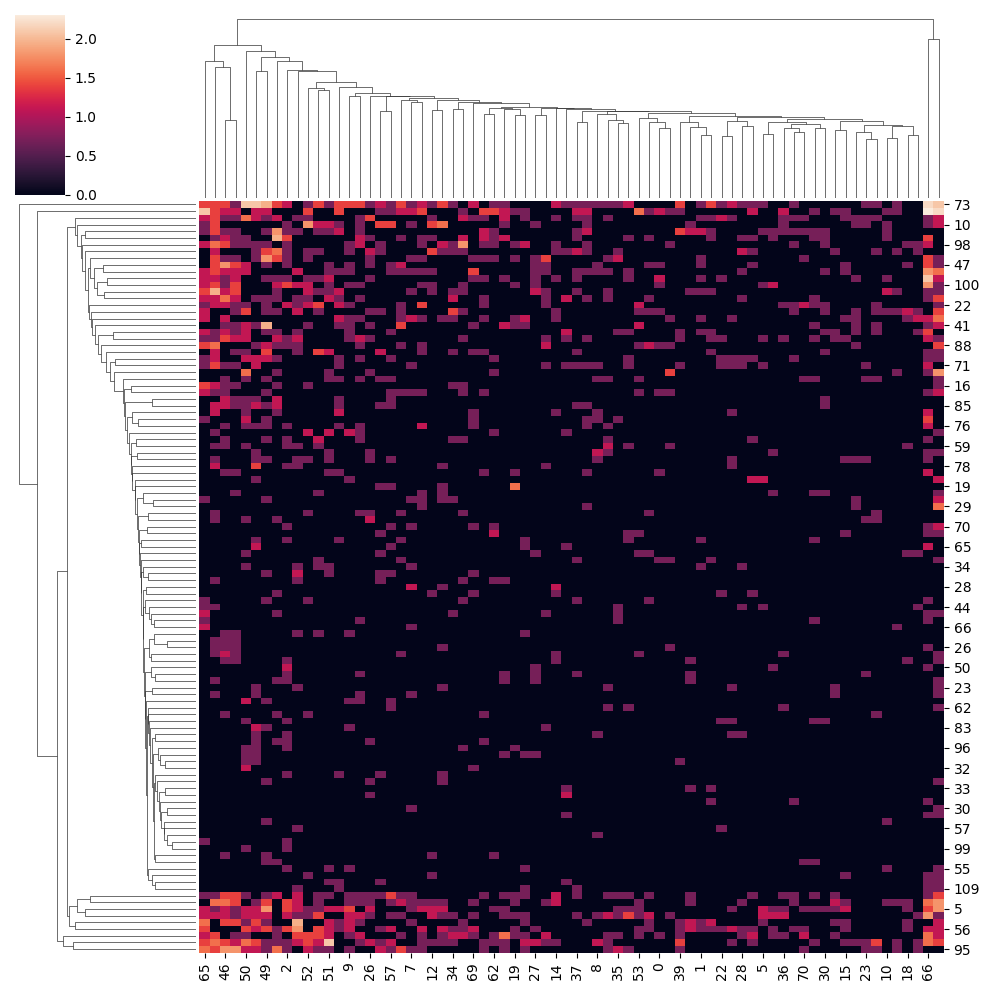

In [5]:
sns.clustermap(np.log1p(ec_mudata["high_abundance_genes"].X.A))

In [6]:
sc.pp.highly_variable_genes(ec_mudata["high_abundance_genes"], layer='raw_counts', n_top_genes=ec_mudata["high_abundance_genes"].shape[1], flavor='seurat_v3')

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='highly_variable_rank', ylabel='total_counts'>

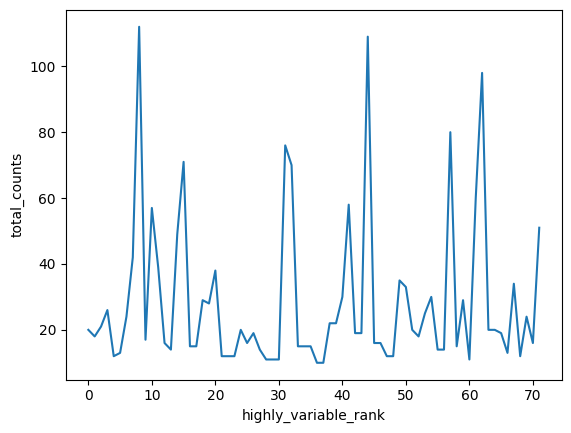

In [7]:
sns.lineplot(data=ec_mudata["high_abundance_genes"].var, x="highly_variable_rank", y="total_counts", color="C0")

### 200 HVG
Selecting the 200 (most) Highly Variables Genes for analysis

In [8]:
hag10_hcc15_hvg200 = ec_mudata["high_abundance_genes"][:, ec_mudata["high_abundance_genes"].var["highly_variable_rank"] <= 200].copy()
hag10_hcc15_hvg200

AnnData object with n_obs × n_vars = 112 × 72
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'genes_match', 'neighbors', 'protein_match', 'umap', 'unmatch_genes', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
    obsp: 'connectivities', 'distances'

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

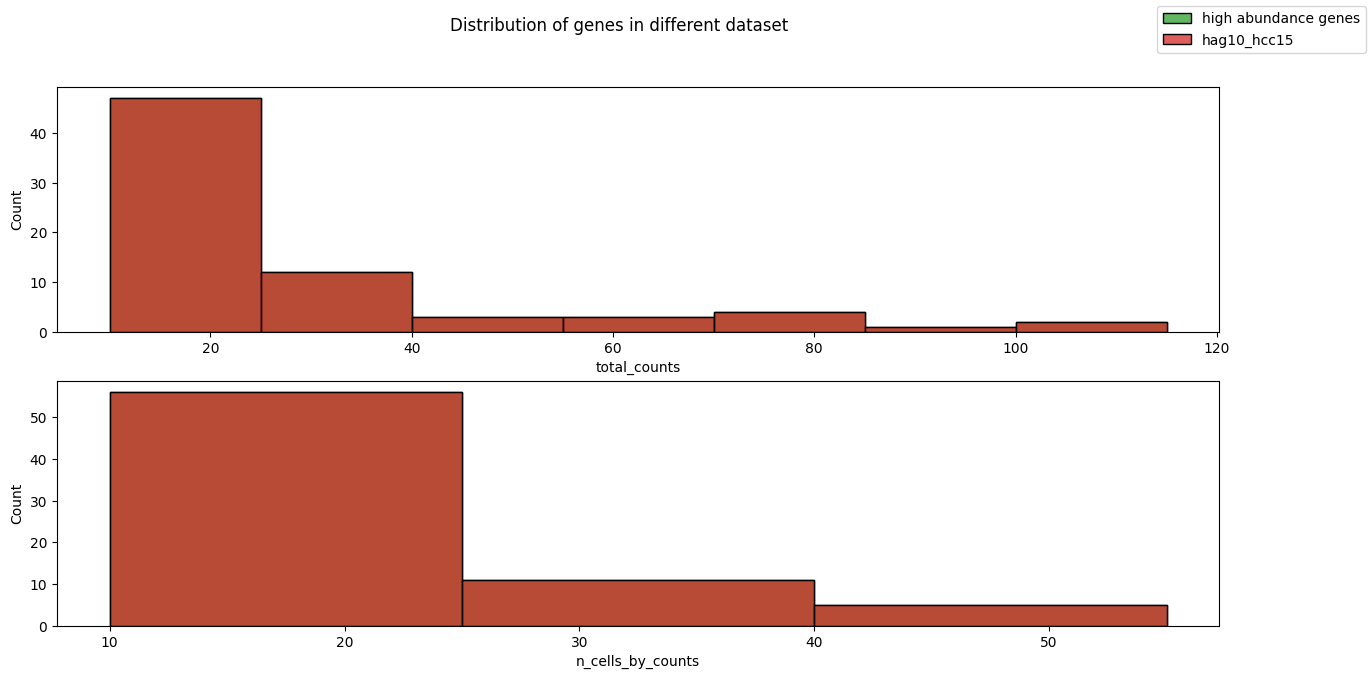

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))
sns.histplot(ec_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])
sns.histplot(hag10_hcc15_hvg200.var["total_counts"], binwidth=15, kde=False, color="C3", label="hag10_hcc15", ax=axes[0])

sns.histplot(ec_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])
sns.histplot(hag10_hcc15_hvg200.var["n_cells_by_counts"], binwidth=15, kde=False, color="C3", ax=axes[1])

#axes[0].set_title("Total counts for genes")
#axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of counts in each cell')

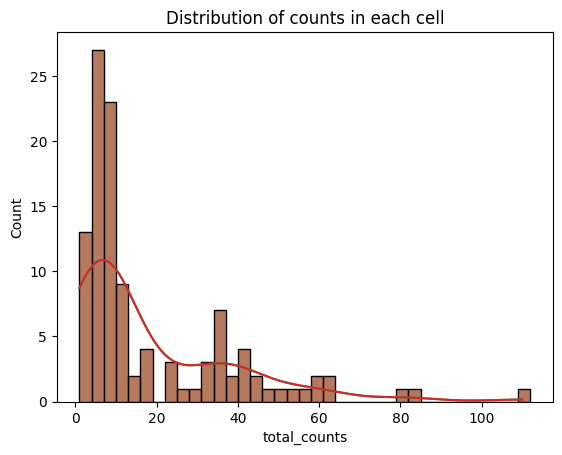

In [10]:
#fig, axes = plt.subplots(1, 1, figsize=(15,7))

sns.histplot(ec_mudata["high_abundance_genes"].obs["total_counts"], binwidth=3, kde=True, color="C2", label="high abundance genes",)
sns.histplot(hag10_hcc15_hvg200.obs["total_counts"], binwidth=3, kde=True, color="C3", label="hag10_hcc15",)

plt.title("Distribution of counts in each cell")

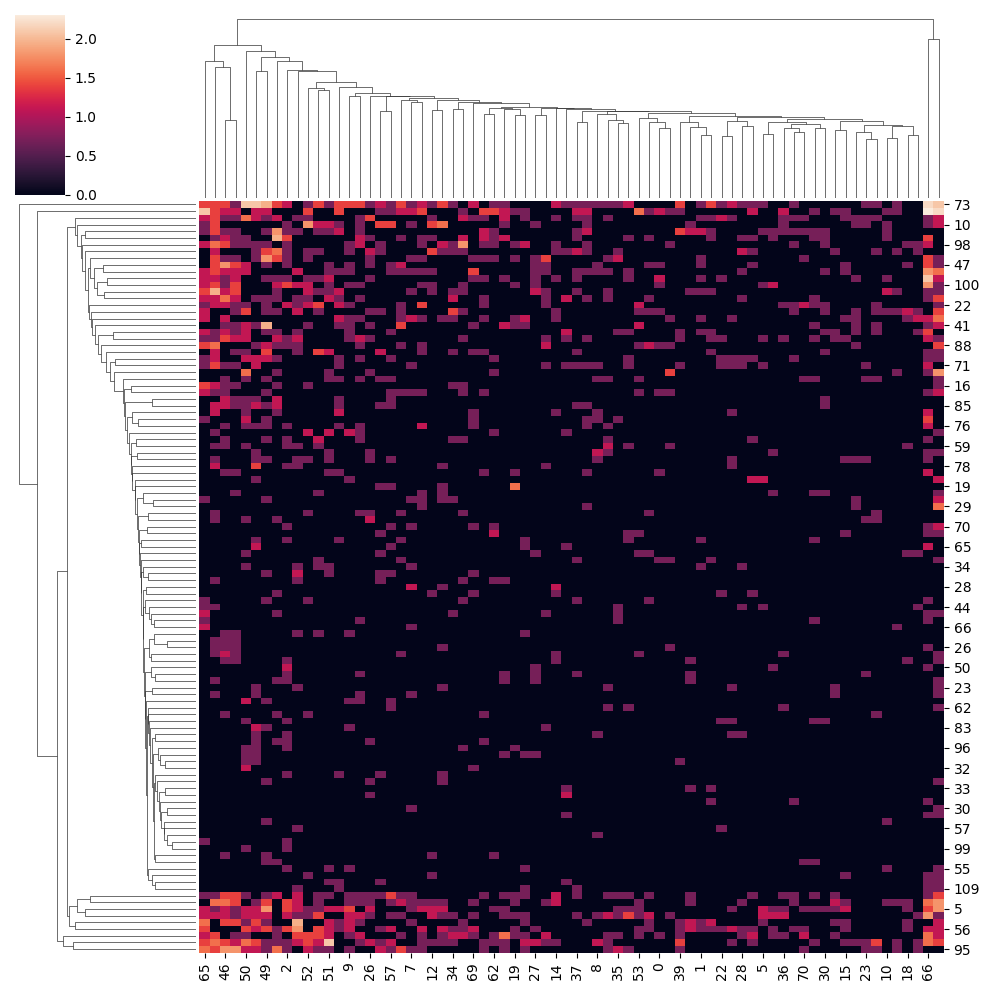

In [11]:
sns.clustermap(np.log1p(hag10_hcc15_hvg200.X.A))

In [12]:
calc_sparsity(np.array(hag10_hcc15_hvg200.X.A,dtype=bool))

0.17485119047619047

In [13]:
cov_hag10_hcc15_hvg200 = empirical_covariance(hag10_hcc15_hvg200.layers["sqrt_counts"].A)

In [14]:
ggl_est = gg_lasso_network_analysis(N=hag10_hcc15_hvg200.shape[0], estimate=cov_hag10_hcc15_hvg200)
ggl_est.create_problem(latent=False)
ggl_est.model_selection(lambda1_range=np.logspace(0, -5, 200))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 53 iterations with status: optimal.
ADMM terminated after 52 iterations with status: optimal.
ADMM terminated after 51 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 50 iterations with status: optimal.
ADMM terminated after 47 iterations with status: optimal.
ADMM terminated after 47 iterations with status: optimal.
ADMM terminated after 46 iterations with status: optimal.
ADMM terminated after 46 iterations with status: optimal.
ADMM terminated after 46 iterations with status: optimal.
ADMM terminated after 45 iterations with status: optimal.
ADMM terminated after 45 iterations with status: optimal.
ADMM terminated after 56 iterations with status: optimal.
ADMM terminated after 60 iterations with status: optimal.
ADMM terminated after 59 iterations with status: optimal.
ADMM terminated after 57 iterations wi

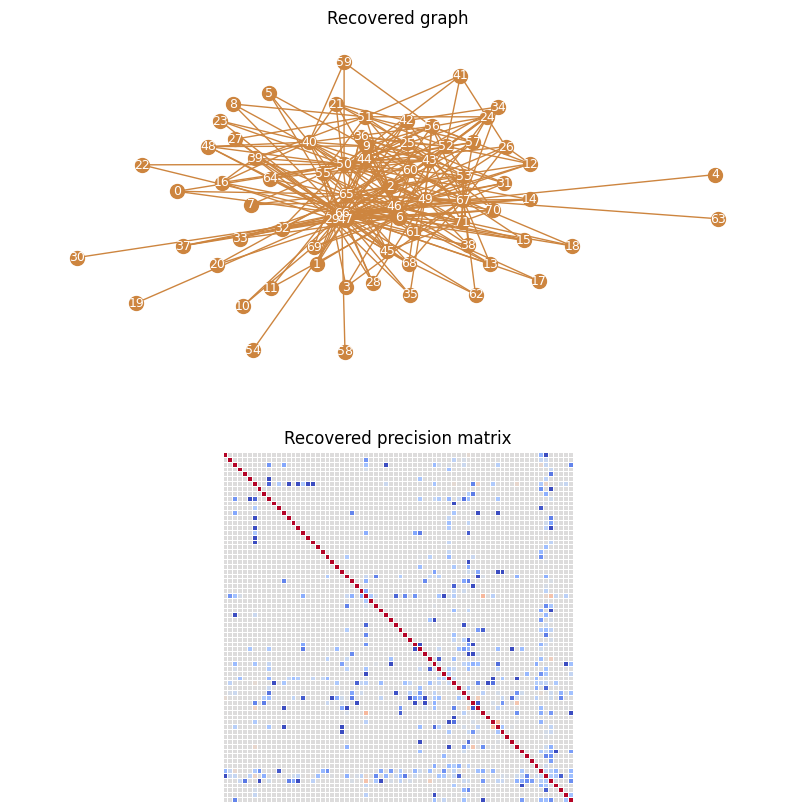

In [15]:
ggl_est.plot_graph_and_percision_matrix(fig_size=(10,10))

In [16]:
sol = ggl_est.P.solution.precision_

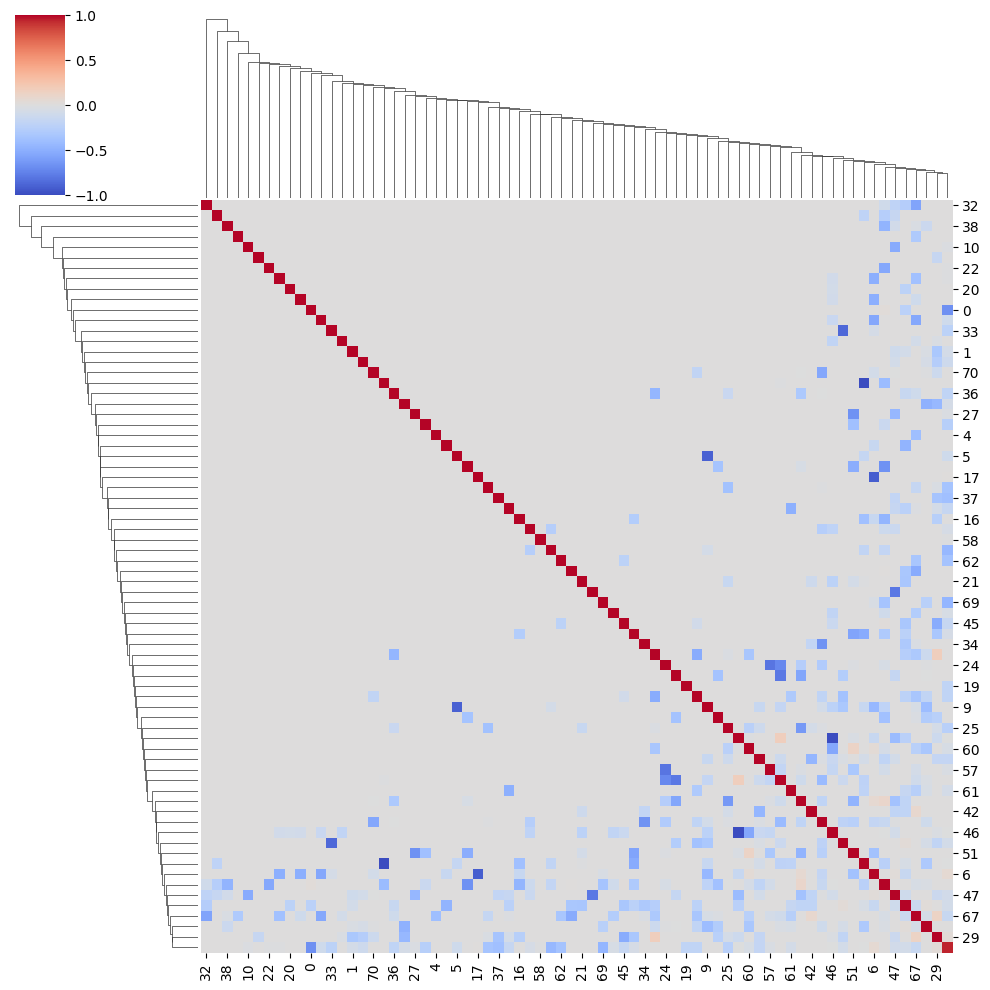

In [17]:
res = sns.clustermap(sol, cmap="coolwarm", vmin=-1, vmax=1)

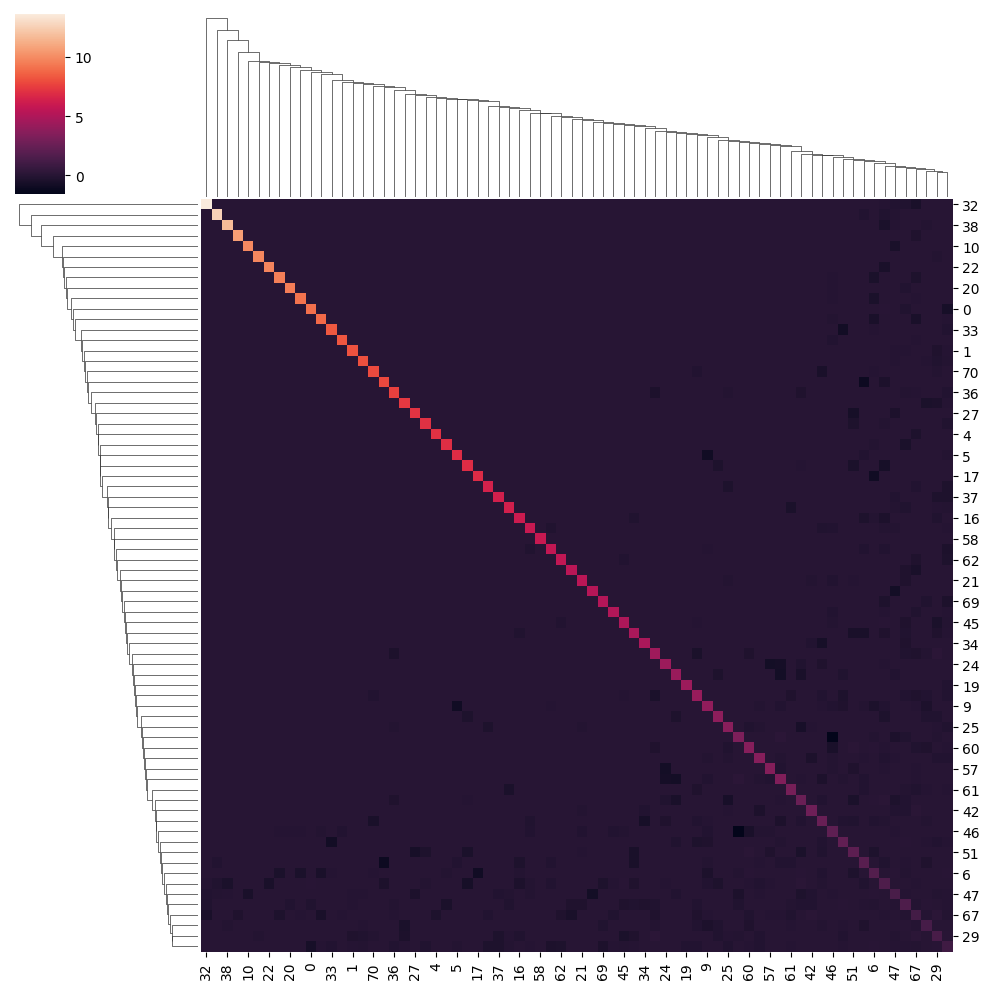

In [18]:
res = sns.clustermap(sol)


In [19]:
ggl_est.P.__dict__

{'S': array([[0.13137755, 0.01339286, 0.01371173, ..., 0.0057398 , 0.00637755,
         0.06058673],
        [0.01339286, 0.12723214, 0.04129464, ..., 0.03794643, 0.03125   ,
         0.02008929],
        [0.01371173, 0.04129464, 0.58729273, ..., 0.0801977 , 0.06728316,
         0.21731505],
        ...,
        [0.0057398 , 0.03794643, 0.0801977 , ..., 0.2471301 , 0.03252551,
         0.09917092],
        [0.00637755, 0.03125   , 0.06728316, ..., 0.03252551, 0.13137755,
         0.09630102],
        [0.06058673, 0.02008929, 0.21731505, ..., 0.09917092, 0.09630102,
         0.37468112]]),
 'N': 112,
 'latent': False,
 'G': None,
 'do_scaling': False,
 'conforming': True,
 'multiple': False,
 'p': 72,
 'K': 1,
 'reg_params': {'lambda1': 0.07401959996915641, 'mu1': 0},
 'modelselect_params': {'lambda1_range': array([1.00000000e+00, 9.43787828e-01, 8.90735464e-01, 8.40665289e-01,
         7.93409667e-01, 7.48810386e-01, 7.06718127e-01, 6.66991966e-01,
         6.29498899e-01, 5.94113398e-

In [20]:
res.dendrogram_row.reordered_ind[:10]

[32, 23, 38, 63, 10, 30, 22, 13, 20, 18]

In [21]:
index_high_corr = hag10_hcc15_hvg200.var.index[res.dendrogram_row.reordered_ind[:10]]
index_high_corr

Index(['cds-NP_252937.1', 'cds-NP_252926.1', 'cds-NP_252945.1',
       'cds-NP_253738.1', 'cds-NP_250491.1', 'cds-NP_252934.1',
       'cds-NP_252312.1', 'cds-NP_251314.1', 'cds-NP_251849.1',
       'cds-NP_251840.1'],
      dtype='object')

In [22]:
hag10_hcc15_hvg200[:,index_high_corr].var

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
cds-NP_252937.1,GSM5456503_Ec_CDS,match,NP_252937.1,10,0.089286,91.071429,10.0,10,True,37.0,0.089286,0.082046,1.008114
cds-NP_252926.1,GSM5456503_Ec_CDS,match,NP_252926.1,10,0.089286,91.071429,10.0,10,True,36.0,0.089286,0.082046,1.008114
cds-NP_252945.1,GSM5456503_Ec_CDS,match,NP_252945.1,11,0.098214,90.178571,11.0,11,True,60.0,0.098214,0.089366,0.857991
cds-NP_253738.1,GSM5456503_Ec_CDS,match,NP_253738.1,12,0.107143,89.285714,12.0,12,True,68.0,0.107143,0.096525,0.789654
cds-NP_250491.1,GSM5456503_Ec_CDS,match,NP_250491.1,10,0.098214,91.071429,11.0,10,True,29.0,0.098214,0.107384,1.030979
cds-NP_252934.1,GSM5456503_Ec_CDS,match,NP_252934.1,13,0.116071,88.392857,13.0,13,True,66.0,0.116071,0.103523,0.804197
cds-NP_252312.1,GSM5456503_Ec_CDS,match,NP_252312.1,10,0.098214,91.071429,11.0,10,True,30.0,0.098214,0.107384,1.030979
cds-NP_251314.1,GSM5456503_Ec_CDS,match,NP_251314.1,11,0.107143,90.178571,12.0,11,True,48.0,0.107143,0.114543,0.937056
cds-NP_251849.1,GSM5456503_Ec_CDS,match,NP_251849.1,10,0.098214,91.071429,11.0,10,True,28.0,0.098214,0.107384,1.030979
cds-NP_251840.1,GSM5456503_Ec_CDS,match,NP_251840.1,11,0.107143,90.178571,12.0,11,True,47.0,0.107143,0.114543,0.937056


In [23]:
hag10_hcc15_hvg200[:,28].var

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
cds-NP_252931.1,GSM5456503_Ec_CDS,match,NP_252931.1,13,0.125,88.392857,14.0,13,True,56.0,0.125,0.128378,0.905593


In [24]:
hag10_hcc15_hvg200.var.total_counts.value_counts()

total_counts
12.0     7
15.0     6
16.0     5
20.0     5
19.0     4
14.0     4
11.0     4
30.0     2
22.0     2
29.0     2
10.0     2
18.0     2
24.0     2
13.0     2
17.0     1
71.0     1
112.0    1
76.0     1
35.0     1
51.0     1
28.0     1
60.0     1
39.0     1
42.0     1
70.0     1
80.0     1
98.0     1
21.0     1
34.0     1
38.0     1
26.0     1
58.0     1
49.0     1
57.0     1
25.0     1
33.0     1
109.0    1
Name: count, dtype: int64